# MCS Algorithms for Order and Chaos Game

### Useful Links
- [Order and Chaos - Wikipedia](https://en.wikipedia.org/wiki/Order_and_Chaos)
- [Order and Chaos - Game simulator](https://ludii.games/details.php?keyword=Order%20and%20Chaos)

**Abstract :** For this project we interested about Order and Chaos game who is very challenging because of is rules. Like in tic-tac-toe players allowed between to state O or X. His particularity come from the fact that both players allowed to play O and X, so the main objective for player 1 and player 2 are different. The first want to make a winning line of 5 successivly same symbole and the other want to make a draw. For this game we tried differente Monte carlo tree search algorithms :
- UCB ?? for ..
- RAVE ?? because ..
- ETC.. TO DO

## Import

In [24]:
import numpy as np
import numpy.random as random
from copy import deepcopy
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import time

## Constant inputs

In [25]:
Dx = 6
Dy = 6
Empty = '-'
# Create the Zobrist hashing table
HashTable = [[ np.random.randint(0, 2**15, Dy).tolist() for _ in range(Dx)] for _ in range(2)]
HashTurn = np.random.randint(0, 2**15)

## Define the Game

### Move class

In [26]:
class Move(object):
    def __init__(self, x, y, symbol):
        self.x = x
        self.y = y
        self.symbol = symbol

    def valid (self, board):
        # Move in the board
        if self.x >= Dx or self.y >= Dy or self.x < 0 or self.y <0:
            return False
        # Move in a free space
        if board.board[self.x][self.y] != Empty:
            return False

        return True

### Class Board

In [27]:
class Board(object):
    def __init__(self):
        #self.history = {'Order' : [], 'Chaos' : []}
        self.turn = 'Order' #Order always start the game
        self.board = [[Empty for _ in range(Dx)] for _ in range(Dy)]
        self.board = np.array(self.board)
        self.nb_moves = 0
        self.h = 0

    def legalMoves(self):
        moves = []
        for i in range (0, Dx):
            for j in range (0, Dy):
                for symb in ['X', 'O']:
                    m = Move (i, j, symb)
                    if m.valid (self):
                        moves.append (m)

        return moves

    def verif_array(self, array):
        if (np.char.count(array, '-').sum() <= 1) and (len(np.unique(array[:5]))==1 or len(np.unique(array[1:]))==1):
            return True
        else:
            return False

    def win(self):
        # Horizontal win
        for row in self.board:
            if self.verif_array(row) == True:
                return True

        # Vertical win
        for col in self.board.T:
            if self.verif_array(col) == True:
                return True

        # Diagonal win
        for i in [-1, 0, 1]:
            diag = np.diagonal(self.board, offset=i)
            if (len(diag)==6) and (self.verif_array(diag) == True) or (np.char.count(diag, '-').sum() < 1) and (len(np.unique(diag))==1):
                return True

            diag_opposite = np.flipud(self.board).diagonal(offset=i)
            if (len(diag_opposite)==6) and (self.verif_array(diag_opposite) == True) or (np.char.count(diag_opposite, '-').sum() < 1) and (len(np.unique(diag_opposite))==1):
                return True

        return False


    def draw(self):
        if self.nb_moves < Dx*Dy:
            return False
        if self.nb_moves >= Dx*Dy and not self.win():
            return True
        return False

    def score(self):
        if self.draw():
            return 0
        if self.win():
            return 1

    def terminal(self):
        if not self.win() and not self.draw():
            return False
        return True

    def __repr__(self):
        return "\n".join(" ".join(row) for row in self.board)

    def play (self, move:Move):
        change_player = {'Order' : 'Chaos', 'Chaos' : 'Order'}
        encode_symbol = {'X' : 0, 'O' : 1}
        if move.valid(self):
            self.board[move.x][move.y] = move.symbol
            # Compute hash
            self.h = self.h ^ HashTable[ encode_symbol[move.symbol] ][move.x][move.y]
            self.h = self.h ^ HashTurn
            # Actualise
            self.turn = change_player[self.turn]
            self.nb_moves += 1

    def playout (self):
        while (True):
            moves = self.legalMoves()
            if self.terminal():
                return self.score()
            n = random.randint(0, len (moves) - 1)
            self.play(moves [n])

## Test the game

### Manually

In [28]:
game = Board()
game.play(Move(0, 0, 'X'))
game.play(Move(1, 1, 'X'))
game.play(Move(2, 2, 'O'))
game.play(Move(3, 3, 'X'))
game.play(Move(4, 4, 'X'))
print(game)
print("Win:", game.win())
print("Draw:", game.draw())
print("End:", game.terminal())
game.play(Move(2, 0, 'O'))
game.play(Move(2, 1, 'O'))
game.play(Move(2, 3, 'O'))
game.play(Move(2, 4, 'O'))
print(game)
print("Win:", game.win())
print("Draw:", game.draw())
print("End:", game.terminal())

X - - - - -
- X - - - -
- - O - - -
- - - X - -
- - - - X -
- - - - - -
Win: False
Draw: False
End: False
X - - - - -
- X - - - -
O O O O O -
- - - X - -
- - - - X -
- - - - - -
Win: True
Draw: False
End: True


### Playout

In [29]:
game = Board()
game.playout()
print(game)
print("Win:", game.win())
print("Draw:", game.draw())
print("End:", game.terminal())

O O X X O X
O O O O X O
X X X X O X
X X X O X O
X O X X X X
O O X X O X
Win: False
Draw: True
End: True


### Win rate after 1000 playout

In [30]:
wins = []
for _ in range(1000):
    game = Board()
    score = game.playout()
    wins.append(score)

print(f"Win rate after 1000 playout: {sum(wins)/1000:.4f}")

Win rate after 1000 playout: 0.8310


# Define algorithms

## UCT

In [31]:
Table = {}
MaxLegalMoves = 2*Dx*Dy
def add(board):
    nplayouts = [0.0 for x in range (MaxLegalMoves)]
    nwins = [0.0 for x in range (MaxLegalMoves)]
    Table[board.h] = [0, nplayouts, nwins]

def look (board):
    return Table.get(board.h, None)

def UCT(board:Board, c=1.41):
    moves = board.legalMoves()
    if board.terminal():
        return board.score()
    t = look(board)
    if t != None:
        bestValue = -1
        n, p, w  = t
        for i, m in enumerate(moves):
            p_m = p[i]
            w_m = w[i]
            if p_m > 0 :
                value = np.abs((board.turn == 'Chaos') - (w_m/p_m) ) + c * np.sqrt(np.log(n)/p_m)
                if value > bestValue:
                    i_best = i
                    bestValue = value
                    bestMove = m
        # Simulation
        b = deepcopy(board)
        b.play(bestMove)
        res = b.playout()
        res = np.abs((board.turn == 'Chaos') - res)
        t[0] +=1
        t[1][i_best] += 1
        t[2][i_best] += res
        
    else:
        add(board)
        b = deepcopy(board)
        rdm_move = random.randint(0, len(moves) - 1)
        b.play(moves[rdm_move])
        res = b.playout()
        res = np.abs((b.turn == 'Chaos') - res)
        # Update Table
        t = look(board)
        t[0] +=1
        t[1][rdm_move] += 1
        t[2][rdm_move] += res
        
        return res
    
def BestMoveUCT(board, iterations=100, T=Table):
    T.clear()
    for i in range (iterations):
        b = deepcopy(board)
        UCT(b)
    t = look (board)
    moves = board.legalMoves()
    bestMove = moves[0]
    bestValue = t[1][0]
    for i in range (1, len(moves)):
        if (t[1][i] > bestValue):
            bestValue = t[1][i]
            bestMove = moves[i]
    return bestMove

## Enhanced Playout Methods

In [32]:
def heuristic_playout(board):
    """Heuristic playout that prioritizes winning moves for Order and blocking moves for Chaos"""
    board_copy = deepcopy(board)
    while not board_copy.terminal():
        winning_move = find_tactical_move(board_copy)
        if winning_move:
            board_copy.play(winning_move)
            continue

        moves = board_copy.legalMoves()
        if not moves:
            break
        n = random.randint(0, len(moves) - 1)
        board_copy.play(moves[n])

    if board_copy.terminal():
        return board_copy.score()
    else:
        return 0

In [33]:
def find_tactical_move(board):
    """Trying to find winning move for Order or blocking move for Chaos"""
    moves = board.legalMoves()

    if board.turn == 'Order':
        for move in moves:
            temp_board = deepcopy(board)
            temp_board.play(move)
            if temp_board.win():
                return move

    else:
        next_board = deepcopy(board)
        next_board.turn = 'Order'
        order_moves = []
        for i in range(Dx):
            for j in range(Dy):
                if next_board.board[i][j] == Empty:
                    for symb in ['X', 'O']:
                        order_moves.append(Move(i, j, symb))

        threat_positions = []
        for move in order_moves:
            if move.valid(next_board):
                temp_board = deepcopy(next_board)
                temp_board.board[move.x][move.y] = move.symbol  #no turn change
                if temp_board.win():
                    threat_positions.append((move.x, move.y))

        if threat_positions:
            pos = threat_positions[0]
            for move in moves:
                if (move.x, move.y) == pos:
                    return move

    return None

In [34]:
def pattern_based_playout(board, exploration_rate=0.2):
    board_copy = deepcopy(board)

    def evaluate_move(board, move):
        temp_board = deepcopy(board)
        temp_board.play(move)

        score = 1

        if board.turn == 'Order':
            directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
            symbol = move.symbol

            for dx, dy in directions:
                consecutive = 1

                for i in range(1, 5):
                    nx, ny = move.x + dx*i, move.y + dy*i
                    if 0 <= nx < Dx and 0 <= ny < Dy and temp_board.board[nx][ny] == symbol:
                        consecutive += 1
                    else:
                        break

                for i in range(1, 5):
                    nx, ny = move.x - dx*i, move.y - dy*i
                    if 0 <= nx < Dx and 0 <= ny < Dy and temp_board.board[nx][ny] == symbol:
                        consecutive += 1
                    else:
                        break

                if consecutive >= 5:
                    score += 100
                elif consecutive == 4:
                    score += 10
                elif consecutive == 3:
                    score += 5
                elif consecutive == 2:
                    score += 2

        else:
            adjacent = [(0,1), (1,0), (1,1), (1,-1), (0,-1), (-1,0), (-1,-1), (-1,1)]
            for dx, dy in adjacent:
                nx, ny = move.x + dx, move.y + dy
                if 0 <= nx < Dx and 0 <= ny < Dy and temp_board.board[nx][ny] != Empty:
                    score += 2

        return score

    while not board_copy.terminal():
        moves = board_copy.legalMoves()
        if not moves:
            break

        if random.random() < exploration_rate:
            chosen_move = moves[random.randint(0, len(moves) - 1)]
        else:
            move_scores = []
            for move in moves:
                score = evaluate_move(board_copy, move)
                move_scores.append((move, score))

            chosen_move = max(move_scores, key=lambda x: x[1])[0]

        board_copy.play(chosen_move)

    return board_copy.score() if board_copy.terminal() else 0

In [35]:
print("Testing improved playout methods:")
wins_heuristic = []
wins_pattern = []

for _ in range(100):
    game_h = Board()
    game_p = Board()

    result_h = heuristic_playout(game_h)
    result_p = pattern_based_playout(game_p)

    wins_heuristic.append(result_h)
    wins_pattern.append(result_p)

print(f"Heuristic playout win rate: {sum(wins_heuristic)/len(wins_heuristic):.4f}")
print(f"Pattern-based playout win rate: {sum(wins_pattern)/len(wins_pattern):.4f}")

Testing improved playout methods:
Heuristic playout win rate: 0.9100
Pattern-based playout win rate: 1.0000


## RAVE

In [36]:
class RAVENode:
    def __init__(self, board, parent=None, move=None):
        self.board = deepcopy(board)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_moves = board.legalMoves()

        self.rave_wins = 0
        self.rave_visits = 0

    def select_child_rave(self, c=1.41, beta=0.5):
        if not self.children:
            return None

        best_value = -float('inf')
        best_child = None

        for child in self.children:
            if child.visits == 0:
                return child

            if child.visits > 0 and self.visits > 0:
                uct_score = (child.wins / child.visits) + c * math.sqrt(2 * math.log(self.visits) / child.visits)
            else:
                uct_score = float('inf')

            if child.rave_visits > 0:
                rave_score = child.rave_wins / child.rave_visits

                b = child.rave_visits / (child.visits + child.rave_visits + 4 * beta * beta * child.visits * child.rave_visits)

                score = (1 - b) * uct_score + b * rave_score
            else:
                score = uct_score

            if score > best_value:
                best_value = score
                best_child = child

        return best_child

    def add_child(self, move):
        child_board = deepcopy(self.board)
        child_board.play(move)
        child = RAVENode(child_board, parent=self, move=move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result

    def update_rave(self, result):
        self.rave_visits += 1
        self.rave_wins += result

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def is_terminal_node(self):
        return self.board.terminal()

In [37]:
def rave_search(board, iterations=1000, playout_policy=pattern_based_playout):
    root = RAVENode(board)

    for _ in range(iterations):
        node = root
        board_state = deepcopy(node.board)
        visited_nodes = []
        action_playout = {}

        while node.is_fully_expanded() and not node.is_terminal_node():
            selected = node.select_child_rave()
            if selected is None:
                break
            node = selected
            if node.move:
                board_state.play(node.move)
                visited_nodes.append(node)
                action_key = (node.move.x, node.move.y, node.move.symbol)
                action_playout[action_key] = node

        if not node.is_terminal_node():
            if len(node.untried_moves) == 0:
                continue

            move = node.untried_moves[0]
            if len(node.untried_moves) > 1:
                idx = random.randint(0, len(node.untried_moves) - 1)
                move = node.untried_moves[idx]

            board_state.play(move)
            node = node.add_child(move)
            visited_nodes.append(node)
            action_key = (move.x, move.y, move.symbol)
            action_playout[action_key] = node

        result = playout_policy(board_state)

        for visited_node in visited_nodes:
            visited_node.update(result)

        for visited_node in visited_nodes:
            if visited_node.parent:
                for sibling in visited_node.parent.children:
                    action_key = (sibling.move.x, sibling.move.y, sibling.move.symbol)
                    if action_key in action_playout:
                        sibling.update_rave(result)

    if not root.children:
        moves = board.legalMoves()
        if not moves:
            return None
        if len(moves) == 1:
            return moves[0]
        return moves[random.randint(0, len(moves) - 1)]

    return sorted(root.children, key=lambda c: c.visits)[-1].move

## GRAVE

In [38]:
class GRAVENode:
    def __init__(self, board, parent=None, move=None):
        self.board = deepcopy(board)
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_moves = board.legalMoves()
        self.key = self._board_key()

    def _board_key(self):
        return str(self.board)

    def select_child_grave(self, amaf_wins, amaf_visits, c=1.41, beta=0.5):
        if not self.children:
            return None

        best_value = -float('inf')
        best_child = None

        for child in self.children:
            if child.visits == 0:
                return child

            if child.visits > 0 and self.visits > 0:
                uct_score = (child.wins / child.visits) + c * math.sqrt(2 * math.log(self.visits) / child.visits)
            else:
                uct_score = float('inf')

            action_key = (child.move.x, child.move.y, child.move.symbol)
            state_action_key = (self.key, action_key)

            if amaf_visits[state_action_key] > 0:
                rave_score = amaf_wins[state_action_key] / amaf_visits[state_action_key]

                b = amaf_visits[state_action_key] / (child.visits + amaf_visits[state_action_key] + 4 * beta * beta * child.visits * amaf_visits[state_action_key])

                score = (1 - b) * uct_score + b * rave_score
            else:
                score = uct_score

            if score > best_value:
                best_value = score
                best_child = child

        return best_child

    def add_child(self, move):
        child_board = deepcopy(self.board)
        child_board.play(move)
        child = GRAVENode(child_board, parent=self, move=move)
        self.untried_moves.remove(move)
        self.children.append(child)
        return child

    def update(self, result):
        self.visits += 1
        self.wins += result

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def is_terminal_node(self):
        return self.board.terminal()

In [39]:
def grave_search(board, iterations=1000, playout_policy=pattern_based_playout):
    root = GRAVENode(board)

    amaf_wins = defaultdict(float)
    amaf_visits = defaultdict(float)

    for _ in range(iterations):
        node = root
        board_state = deepcopy(node.board)
        visited_states = []

        while node.is_fully_expanded() and not node.is_terminal_node():
            selected = node.select_child_grave(amaf_wins, amaf_visits)
            if selected is None:
                break
            node = selected
            if node.move:
                board_state.play(node.move)
                state_key = node.key
                action_key = (node.move.x, node.move.y, node.move.symbol)
                visited_states.append((state_key, action_key))

        if not node.is_terminal_node():
            if len(node.untried_moves) == 0:
                continue

            move = node.untried_moves[0]
            if len(node.untried_moves) > 1:
                idx = random.randint(0, len(node.untried_moves) - 1)
                move = node.untried_moves[idx]

            board_state.play(move)
            node = node.add_child(move)
            state_key = node.key
            action_key = (move.x, move.y, move.symbol)
            visited_states.append((state_key, action_key))

        result = playout_policy(board_state)

        current = node
        while current is not None:
            current.update(result)
            current = current.parent

        for state_key, action_key in visited_states:
            amaf_visits[(state_key, action_key)] += 1
            amaf_wins[(state_key, action_key)] += result

    if not root.children:
        moves = board.legalMoves()
        if not moves:
            return None
        if len(moves) == 1:
            return moves[0]
        return moves[random.randint(0, len(moves) - 1)]

    return sorted(root.children, key=lambda c: c.visits)[-1].move

## NRPA

In [40]:
def nrpa_search(board, level=1, iterations=20):
    policy = defaultdict(float)

    def choose_move(board, policy):
        moves = board.legalMoves()
        if not moves:
            return None

        weights = []
        for move in moves:
            key = (move.x, move.y, move.symbol)
            weights.append(math.exp(policy[key]))

        total = sum(weights)
        if total == 0:
            return moves[random.randint(0, len(moves) - 1)]

        r = random.random() * total
        cumulative = 0
        for i, weight in enumerate(weights):
            cumulative += weight
            if cumulative > r:
                return moves[i]

        return moves[-1]

    def adapt_policy(policy, sequence, result):
        new_policy = defaultdict(float)
        for key in policy:
            new_policy[key] = policy[key]

        alpha = 0.1
        for move in sequence:
            key = (move.x, move.y, move.symbol)
            new_policy[key] += alpha * result

        return new_policy

    def playout(board, policy):
        sequence = []
        curr_board = deepcopy(board)

        while not curr_board.terminal():
            move = choose_move(curr_board, policy)
            if move is None:
                break
            sequence.append(move)
            curr_board.play(move)

        result = curr_board.score() if curr_board.terminal() else 0
        return sequence, result

    def nested_search(board, policy, level, n):
        if level == 0:
            return playout(board, policy)

        best_sequence = []
        best_score = -float('inf')

        for _ in range(n):
            sequence, score = nested_search(board, policy, level - 1, n)
            if score > best_score:
                best_score = score
                best_sequence = sequence

            policy = adapt_policy(policy, sequence, score)

        return best_sequence, best_score

    sequence, _ = nested_search(board, policy, level, iterations)

    if sequence:
        return sequence[0]

    moves = board.legalMoves()
    if not moves:
        return None
    return moves[random.randint(0, len(moves) - 1)]

## NMCS



In [41]:
def nmcs_search(board, level=1):

    def random_playout(curr_board):
        board_copy = deepcopy(curr_board)

        while not board_copy.terminal():
            moves = board_copy.legalMoves()
            if not moves:
                break
            move = moves[random.randint(0, len(moves) - 1)]
            board_copy.play(move)

        return board_copy.score() if board_copy.terminal() else 0

    def nmcs(curr_board, level):
        if curr_board.terminal():
            return None, curr_board.score()

        if level == 0:
            moves = curr_board.legalMoves()
            if not moves:
                return None, 0

            best_move = moves[random.randint(0, len(moves) - 1)]
            next_board = deepcopy(curr_board)
            next_board.play(best_move)
            return best_move, random_playout(next_board)

        best_score = -float('inf')
        best_move = None

        for move in curr_board.legalMoves():
            next_board = deepcopy(curr_board)
            next_board.play(move)

            _, score = nmcs(next_board, level - 1)

            if score > best_score:
                best_score = score
                best_move = move

        return best_move, best_score

    best_move, _ = nmcs(deepcopy(board), level)

    if best_move:
        return best_move

    moves = board.legalMoves()
    if not moves:
        return None
    return moves[random.randint(0, len(moves) - 1)]

## Testing Framework for Algorithm Comparison

In [42]:
def test_algorithm(algo_fn, num_games=20, opponent="random", algo_role="Order"):
    wins = 0
    avg_time = 0
    game_lengths = []

    for _ in range(num_games):
        game = Board()
        moves_count = 0
        algo_time = 0

        while not game.terminal() and moves_count < 100:
            curr_player = game.turn

            if (curr_player == 'Order' and algo_role == 'Order') or \
               (curr_player == 'Chaos' and algo_role == 'Chaos'):
                start_time = time.time()
                move = algo_fn(game)
                algo_time += time.time() - start_time

                if not isinstance(move, Move):
                    legal_moves = game.legalMoves()
                    if legal_moves:
                        move = legal_moves[random.randint(0, len(legal_moves) - 1)]
                    else:
                        break
            else:
                if opponent == "random":
                    moves = game.legalMoves()
                    if moves:
                        move = moves[random.randint(0, len(moves) - 1)]
                    else:
                        break
                elif opponent == "heuristic":
                    board_copy = deepcopy(game)
                    winning_move = find_tactical_move(board_copy)
                    if winning_move:
                        move = winning_move
                    else:
                        moves = game.legalMoves()
                        if moves:
                            move = moves[random.randint(0, len(moves) - 1)]
                        else:
                            break
                else:
                    opponent_move = opponent(game)
                    if not isinstance(opponent_move, Move):
                        moves = game.legalMoves()
                        if moves:
                            move = moves[random.randint(0, len(moves) - 1)]
                        else:
                            break
                    else:
                        move = opponent_move

            if isinstance(move, Move):
                game.play(move)
                moves_count += 1
            else:
                break

        if algo_role == 'Order':
            if game.win():
                wins += 1
        else:
            if not game.win():
                wins += 1

        avg_time += algo_time / num_games
        game_lengths.append(moves_count)

    win_rate = wins / num_games
    return {
        'win_rate': win_rate,
        'avg_time': avg_time,
        'avg_length': sum(game_lengths) / len(game_lengths)
    }

In [51]:
def compare_algorithms(iterations=100, opponent="random", opponent_name=None):
    opponent_name = str(opponent)
    
    algorithms = {
        'UCT': lambda b: BestMoveUCT(b, iterations=iterations),
        'RAVE': lambda b: rave_search(b, iterations=iterations, playout_policy=pattern_based_playout),
        'GRAVE': lambda b: grave_search(b, iterations=iterations, playout_policy=pattern_based_playout),
        'NRPA': lambda b: nrpa_search(b, level=1, iterations=10),
        'NMCS': lambda b: nmcs_search(b, level=1),
        'Random': lambda b: b.legalMoves()[random.randint(0, len(b.legalMoves()) - 1)] if b.legalMoves() else None,
        'Heuristic': lambda b: find_tactical_move(b) or b.legalMoves()[random.randint(0, len(b.legalMoves()) - 1)] if b.legalMoves() else None
    }

    if opponent_name != "random" and opponent_name != "heuristic":
        opponent = algorithms[opponent_name]
        
    order_results = {}
    for name, algo in algorithms.items():
        print(f"Testing {name} as Order vs {opponent_name} Chaos")
        order_results[name] = test_algorithm(algo, num_games=50, opponent=opponent, algo_role='Order')

    chaos_results = {}
    for name, algo in algorithms.items():
        print(f"Testing {name} as Chaos vs {opponent_name} Order")
        chaos_results[name] = test_algorithm(algo, num_games=50, opponent=opponent, algo_role='Chaos')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    names = list(order_results.keys())
    win_rates = [result['win_rate'] for result in order_results.values()]
    plt.bar(names, win_rates)
    plt.title(f'Win Rates as Order vs {opponent_name} Chaos')
    plt.ylim(0, 1)
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    names = list(chaos_results.keys())
    win_rates = [result['win_rate'] for result in chaos_results.values()]
    plt.bar(names, win_rates)
    plt.title(f'Win Rates as Chaos vs {opponent_name} Order')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'algorithm_comparison_{opponent_name}.png')
    plt.show()

    return order_results, chaos_results

Testing UCT as Order vs Random Chaos
Testing RAVE as Order vs Random Chaos
Testing GRAVE as Order vs Random Chaos
Testing NRPA as Order vs Random Chaos
Testing NMCS as Order vs Random Chaos
Testing Random as Order vs Random Chaos
Testing Heuristic as Order vs Random Chaos
Testing UCT as Chaos vs Random Order
Testing RAVE as Chaos vs Random Order
Testing GRAVE as Chaos vs Random Order
Testing NRPA as Chaos vs Random Order
Testing NMCS as Chaos vs Random Order
Testing Random as Chaos vs Random Order
Testing Heuristic as Chaos vs Random Order


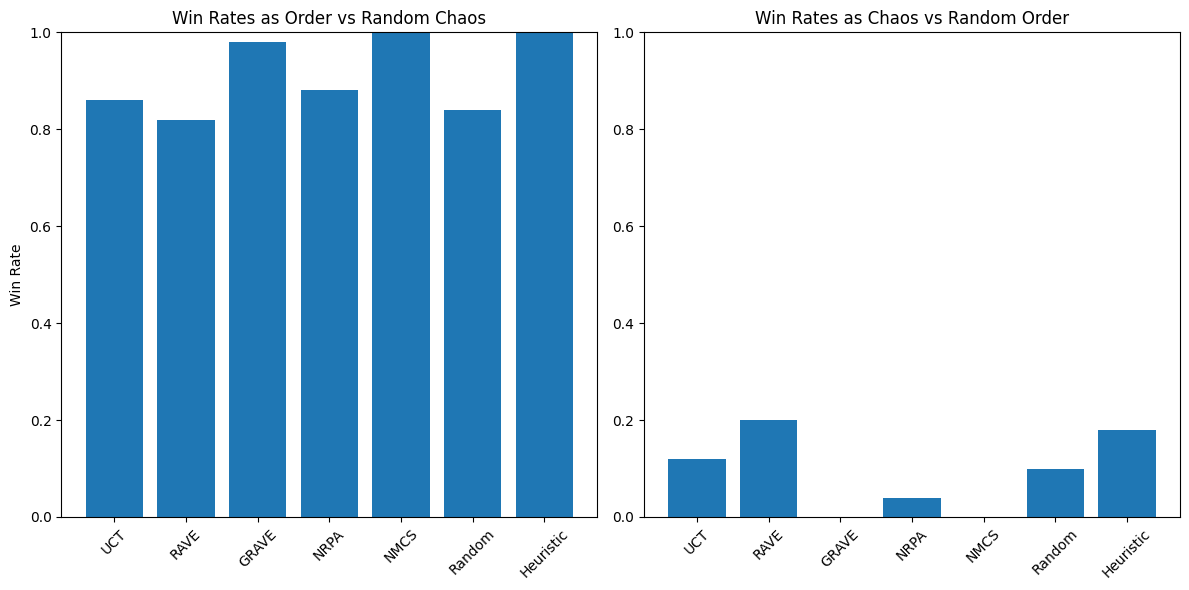

({'UCT': {'win_rate': 0.86,
   'avg_time': 6.864451360702514,
   'avg_length': 29.72},
  'RAVE': {'win_rate': 0.82,
   'avg_time': 7.069513545036315,
   'avg_length': 29.5},
  'GRAVE': {'win_rate': 0.98,
   'avg_time': 6.815515084266663,
   'avg_length': 29.18},
  'NRPA': {'win_rate': 0.88,
   'avg_time': 0.751667914390564,
   'avg_length': 30.1},
  'NMCS': {'win_rate': 1.0,
   'avg_time': 2.7851728534698474,
   'avg_length': 17.48},
  'Random': {'win_rate': 0.84,
   'avg_time': 0.0031084346771240237,
   'avg_length': 29.54},
  'Heuristic': {'win_rate': 1.0,
   'avg_time': 0.06861135482788083,
   'avg_length': 19.6}},
 {'UCT': {'win_rate': 0.12,
   'avg_time': 6.554944024085997,
   'avg_length': 29.56},
  'RAVE': {'win_rate': 0.2,
   'avg_time': 6.472029724121094,
   'avg_length': 29.76},
  'GRAVE': {'win_rate': 0.0,
   'avg_time': 6.304329915046692,
   'avg_length': 28.38},
  'NRPA': {'win_rate': 0.04,
   'avg_time': 0.7299828433990478,
   'avg_length': 29.0},
  'NMCS': {'win_rate': 0

In [44]:
compare_algorithms()

Testing UCT as Order vs heuristic Chaos
Testing RAVE as Order vs heuristic Chaos
Testing GRAVE as Order vs heuristic Chaos
Testing NRPA as Order vs heuristic Chaos
Testing NMCS as Order vs heuristic Chaos
Testing Random as Order vs heuristic Chaos
Testing Heuristic as Order vs heuristic Chaos
Testing UCT as Chaos vs heuristic Order
Testing RAVE as Chaos vs heuristic Order
Testing GRAVE as Chaos vs heuristic Order
Testing NRPA as Chaos vs heuristic Order
Testing NMCS as Chaos vs heuristic Order
Testing Random as Chaos vs heuristic Order
Testing Heuristic as Chaos vs heuristic Order


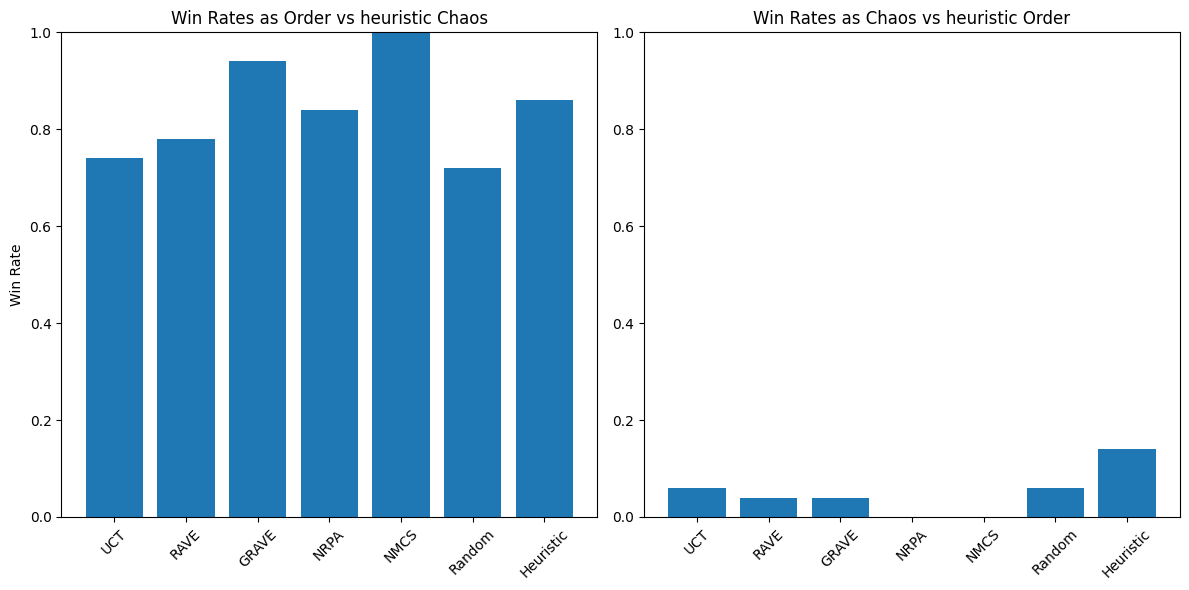

({'UCT': {'win_rate': 0.74,
   'avg_time': 6.6022625303268425,
   'avg_length': 27.74},
  'RAVE': {'win_rate': 0.78,
   'avg_time': 7.067109417915343,
   'avg_length': 27.2},
  'GRAVE': {'win_rate': 0.94,
   'avg_time': 6.603947768211365,
   'avg_length': 24.56},
  'NRPA': {'win_rate': 0.84,
   'avg_time': 0.6614936876296996,
   'avg_length': 24.82},
  'NMCS': {'win_rate': 1.0,
   'avg_time': 2.3382517719268803,
   'avg_length': 13.28},
  'Random': {'win_rate': 0.72,
   'avg_time': 0.003360171318054199,
   'avg_length': 26.88},
  'Heuristic': {'win_rate': 0.86,
   'avg_time': 0.08039635658264158,
   'avg_length': 24.06}},
 {'UCT': {'win_rate': 0.06, 'avg_time': 5.408194451332092, 'avg_length': 21.6},
  'RAVE': {'win_rate': 0.04,
   'avg_time': 5.219501929283141,
   'avg_length': 20.32},
  'GRAVE': {'win_rate': 0.04,
   'avg_time': 5.4950733327865615,
   'avg_length': 20.96},
  'NRPA': {'win_rate': 0.0,
   'avg_time': 0.5611661529541017,
   'avg_length': 20.78},
  'NMCS': {'win_rate': 0

In [48]:
compare_algorithms(opponent="heuristic")

Testing UCT as Order vs UCT Chaos
Testing RAVE as Order vs UCT Chaos
Testing GRAVE as Order vs UCT Chaos
Testing NRPA as Order vs UCT Chaos
Testing NMCS as Order vs UCT Chaos
Testing Random as Order vs UCT Chaos
Testing Heuristic as Order vs UCT Chaos
Testing UCT as Chaos vs UCT Order
Testing RAVE as Chaos vs UCT Order
Testing GRAVE as Chaos vs UCT Order
Testing NRPA as Chaos vs UCT Order
Testing NMCS as Chaos vs UCT Order
Testing Random as Chaos vs UCT Order
Testing Heuristic as Chaos vs UCT Order


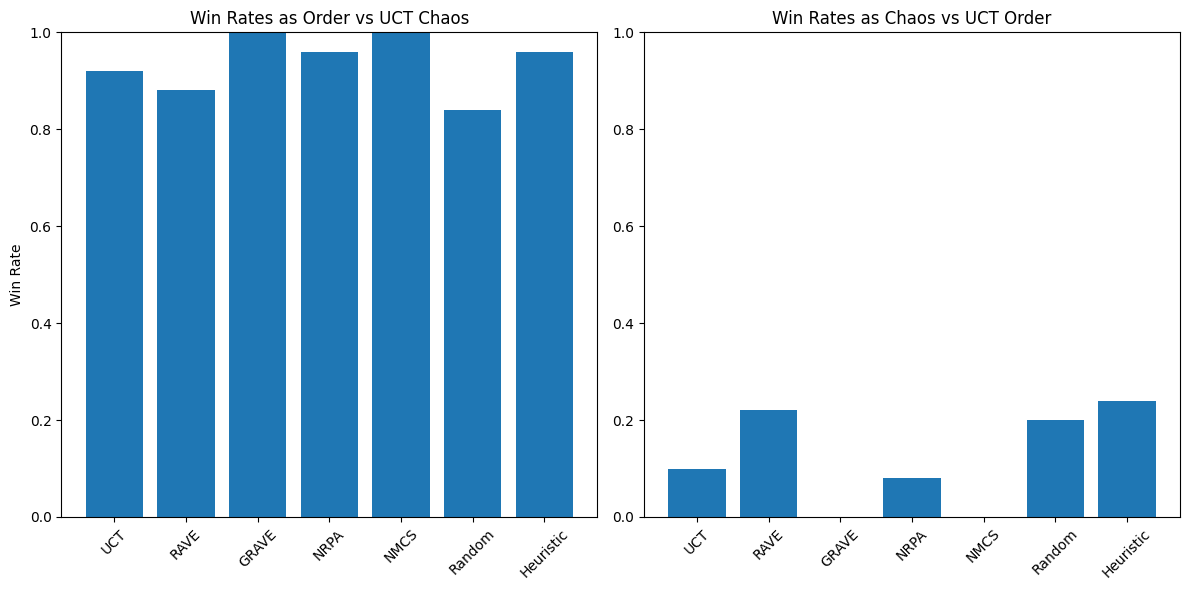

Testing UCT as Order vs RAVE Chaos
Testing RAVE as Order vs RAVE Chaos
Testing GRAVE as Order vs RAVE Chaos
Testing NRPA as Order vs RAVE Chaos
Testing NMCS as Order vs RAVE Chaos
Testing Random as Order vs RAVE Chaos
Testing Heuristic as Order vs RAVE Chaos
Testing UCT as Chaos vs RAVE Order
Testing RAVE as Chaos vs RAVE Order
Testing GRAVE as Chaos vs RAVE Order
Testing NRPA as Chaos vs RAVE Order
Testing NMCS as Chaos vs RAVE Order
Testing Random as Chaos vs RAVE Order
Testing Heuristic as Chaos vs RAVE Order


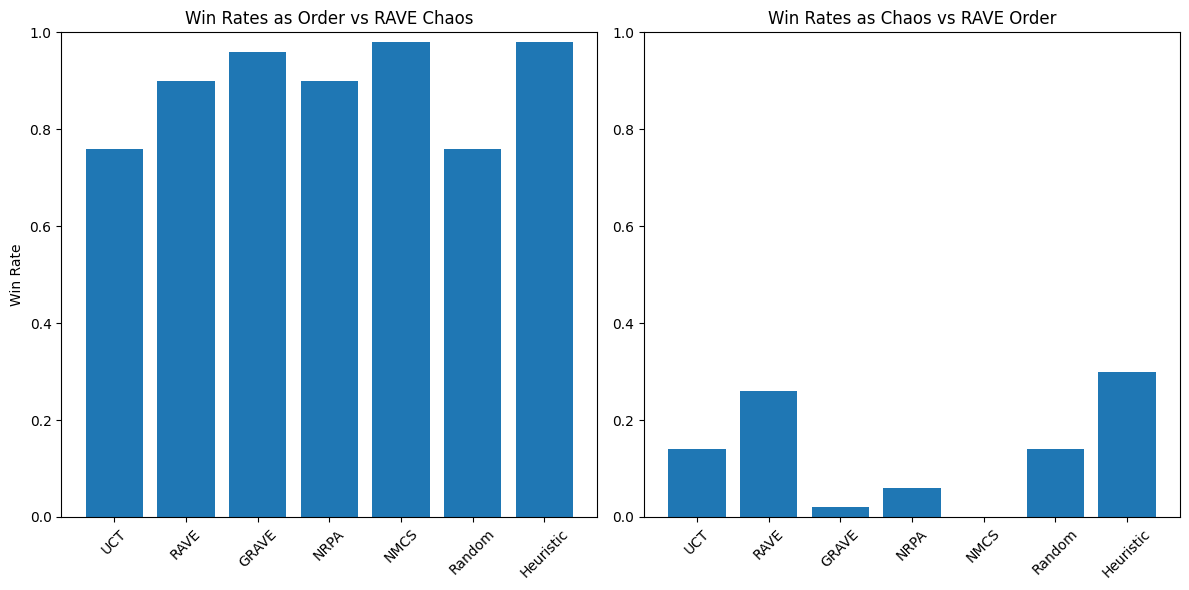

Testing UCT as Order vs GRAVE Chaos
Testing RAVE as Order vs GRAVE Chaos
Testing GRAVE as Order vs GRAVE Chaos
Testing NRPA as Order vs GRAVE Chaos
Testing NMCS as Order vs GRAVE Chaos
Testing Random as Order vs GRAVE Chaos
Testing Heuristic as Order vs GRAVE Chaos
Testing UCT as Chaos vs GRAVE Order
Testing RAVE as Chaos vs GRAVE Order
Testing GRAVE as Chaos vs GRAVE Order
Testing NRPA as Chaos vs GRAVE Order
Testing NMCS as Chaos vs GRAVE Order
Testing Random as Chaos vs GRAVE Order
Testing Heuristic as Chaos vs GRAVE Order


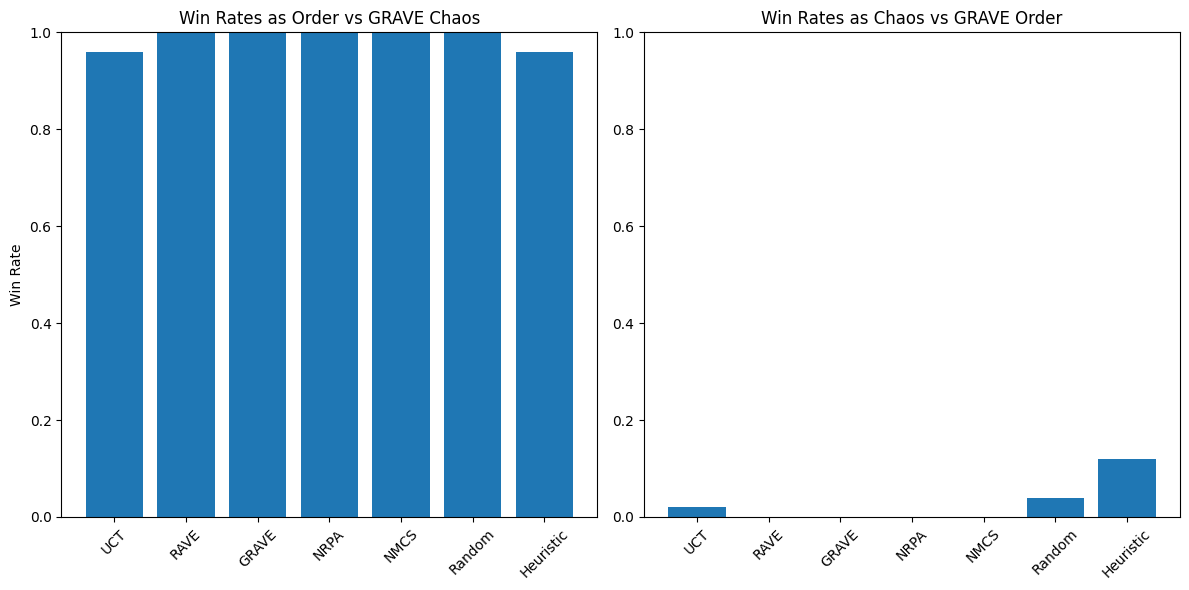

Testing UCT as Order vs NRPA Chaos
Testing RAVE as Order vs NRPA Chaos
Testing GRAVE as Order vs NRPA Chaos
Testing NRPA as Order vs NRPA Chaos
Testing NMCS as Order vs NRPA Chaos
Testing Random as Order vs NRPA Chaos
Testing Heuristic as Order vs NRPA Chaos
Testing UCT as Chaos vs NRPA Order
Testing RAVE as Chaos vs NRPA Order
Testing GRAVE as Chaos vs NRPA Order
Testing NRPA as Chaos vs NRPA Order
Testing NMCS as Chaos vs NRPA Order
Testing Random as Chaos vs NRPA Order
Testing Heuristic as Chaos vs NRPA Order


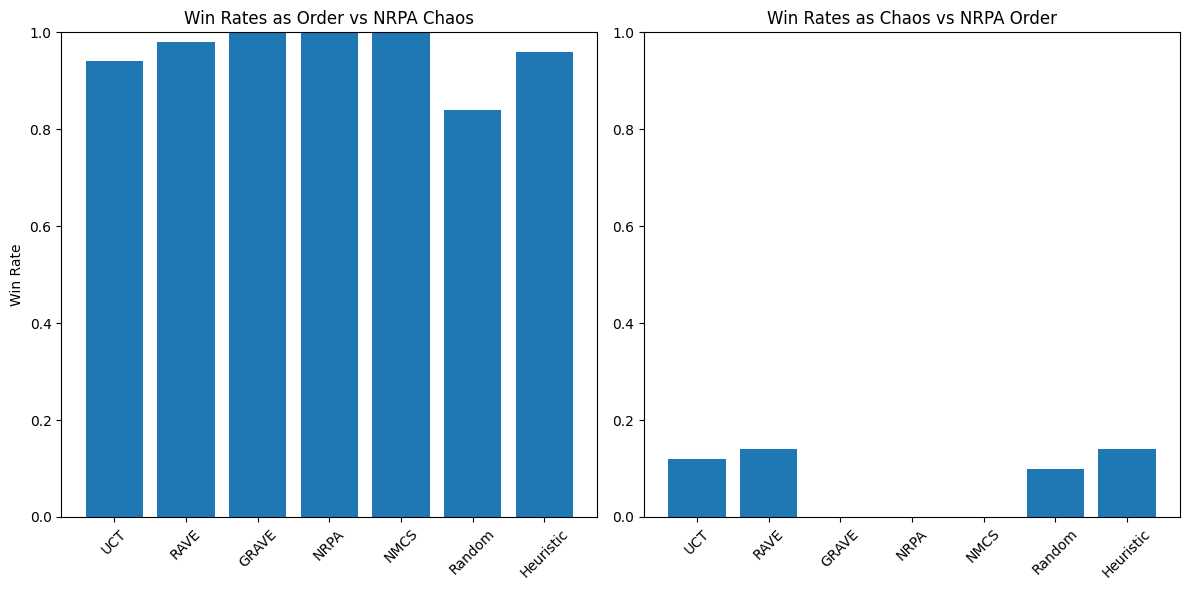

Testing UCT as Order vs NMCS Chaos
Testing RAVE as Order vs NMCS Chaos
Testing GRAVE as Order vs NMCS Chaos
Testing NRPA as Order vs NMCS Chaos
Testing NMCS as Order vs NMCS Chaos
Testing Random as Order vs NMCS Chaos
Testing Heuristic as Order vs NMCS Chaos
Testing UCT as Chaos vs NMCS Order
Testing RAVE as Chaos vs NMCS Order
Testing GRAVE as Chaos vs NMCS Order
Testing NRPA as Chaos vs NMCS Order
Testing NMCS as Chaos vs NMCS Order
Testing Random as Chaos vs NMCS Order
Testing Heuristic as Chaos vs NMCS Order


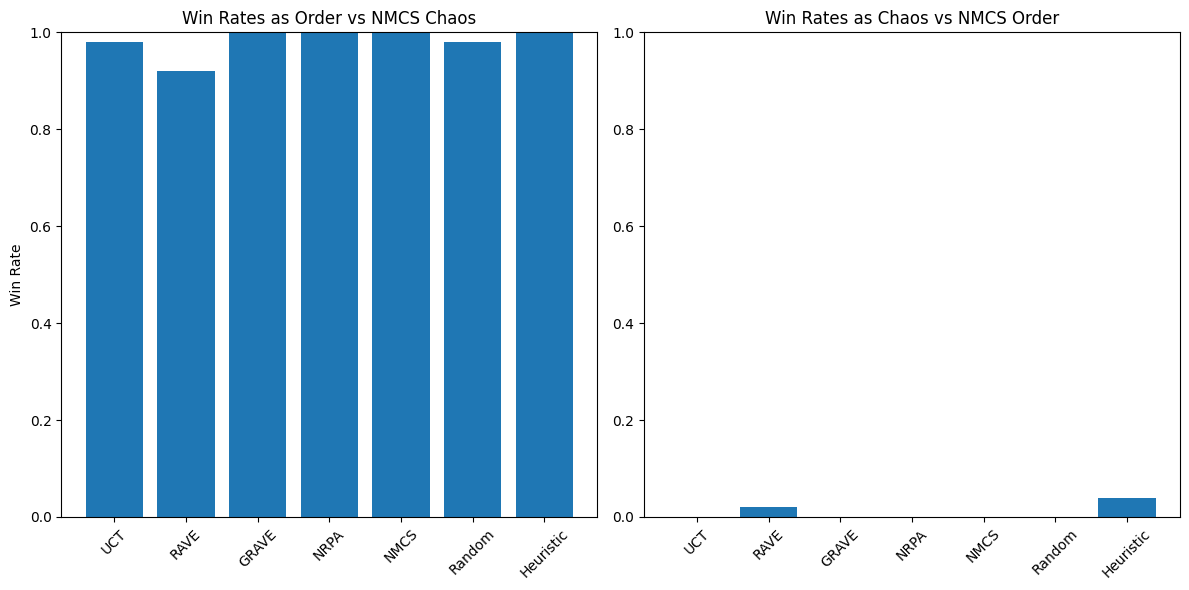

Testing UCT as Order vs Random Chaos
Testing RAVE as Order vs Random Chaos
Testing GRAVE as Order vs Random Chaos
Testing NRPA as Order vs Random Chaos
Testing NMCS as Order vs Random Chaos
Testing Random as Order vs Random Chaos
Testing Heuristic as Order vs Random Chaos
Testing UCT as Chaos vs Random Order
Testing RAVE as Chaos vs Random Order
Testing GRAVE as Chaos vs Random Order
Testing NRPA as Chaos vs Random Order
Testing NMCS as Chaos vs Random Order
Testing Random as Chaos vs Random Order
Testing Heuristic as Chaos vs Random Order


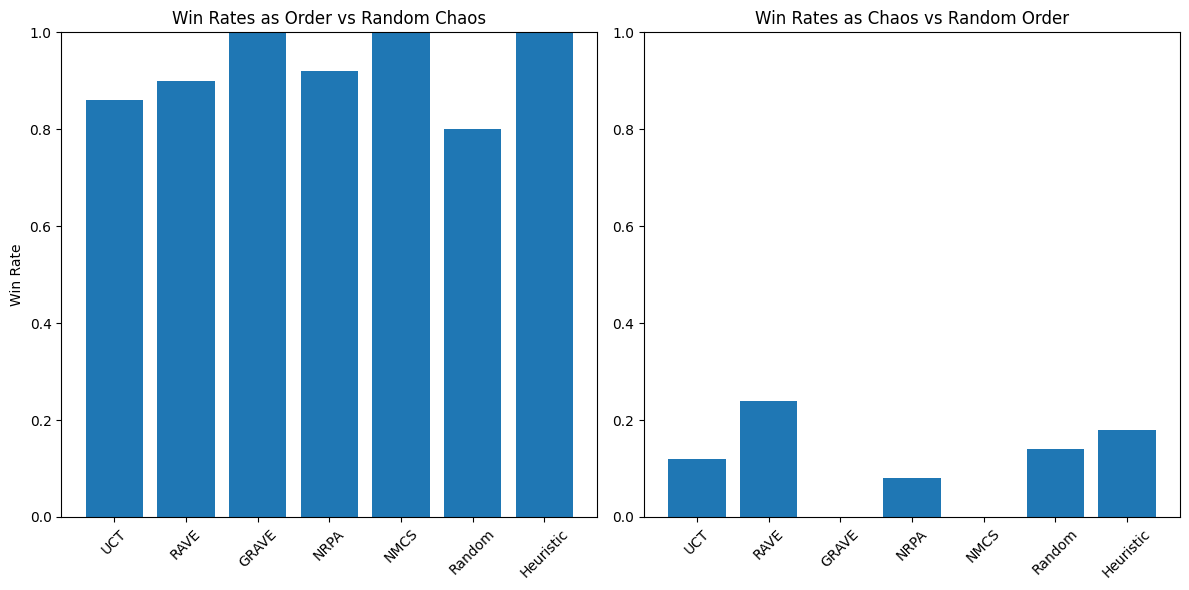

In [52]:
algorithms_names = ['UCT', 'RAVE', 'GRAVE', 'NRPA', 'NMCS', 'Random']
for name in algorithms_names:
    compare_algorithms(iterations=100, opponent=name, opponent_name=None)
        